# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

### Background:
Used car sales dealership wants to know what drives the price of the car so that they can appropriately price the car to gain buy or sell the used cars.
### Business Objectives: 
Identify what are the features or attributes that drives the price of the car. Set the price for the car for sale based on findings.
### Business Success Criteria: 
Set the car price appropriately either for buying or selling to gain maximum profitability
### Access Situation: 
We need to identify the dataset that contains several features of any given car such as make, model, odometer reading, condition, color, location etc.
### Risks: 
There may be a possibility of the data is not accurate or insufficient or not useful
### Costs/Benefits: 
The cost to run analysis to give the price range for any given car so that the delarship can sell appropriately.
### Data Mining/Success goals: 
Identify data, collect the data elements, and samples for various sources. Here the data set is given.
### Project Plan: 
Prepare a project plan to collect data, resources, data analysis,  modelling, deployment and monitoring.
### Tools: 
Linear Regression, Python, Jupyter notebook, and several algorithms, validations etc.


### Data Understanding

### Collect Initial Data:
Run several campaigns to collect the data. Here we got the dataset, so we are not doing anything.
### Describe Data:
The data has 426880 data points with 18 features with several data types.
### Explore Data: 
Explore the data with techniques to identify what features are important using several plots, detecting outliers, treat missing values,data type changes, data cleansing, and null checks etc.
### Verify Data Quality: 
Inspect the data for quality, consistency, range, and length etc.

In [1]:
from warnings import filterwarnings 
filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [2]:
data = pd.read_csv('data/vehicles.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
data.isna().sum().sort_values()

id                   0
price                0
state                0
region               0
year              1205
transmission      2556
fuel              3013
odometer          4400
model             5277
title_status      8242
manufacturer     17646
type             92858
paint_color     130203
drive           130567
VIN             161042
condition       174104
cylinders       177678
size            306361
dtype: int64

In [6]:
data.eq(0).sum().sort_values()

id                  0
type                0
size                0
drive               0
VIN                 0
transmission        0
title_status        0
paint_color         0
fuel                0
condition           0
model               0
manufacturer        0
year                0
region              0
cylinders           0
state               0
odometer         1965
price           32895
dtype: int64

In [7]:
unique_values = data.nunique().sort_values()
unique_values

drive                3
transmission         3
size                 4
fuel                 5
condition            6
title_status         6
cylinders            8
paint_color         12
type                13
manufacturer        42
state               51
year               114
region             404
price            15655
model            29649
odometer        104870
VIN             118246
id              426880
dtype: int64

In [8]:
pd.Series({col:data[col].unique() for col in data})

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

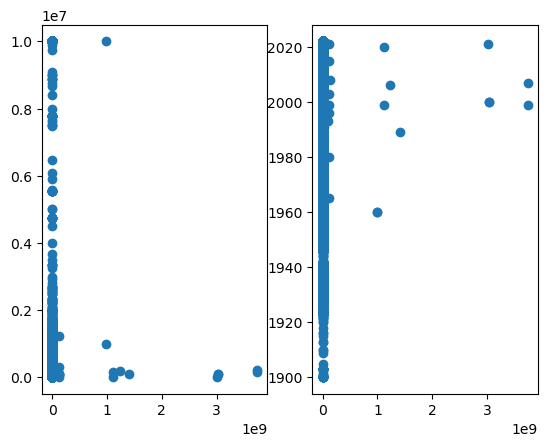

In [9]:
fig, axes = plt.subplots(ncols=2)
for i, yvar in enumerate(['odometer', 'year']):
    axes[i].scatter(data['price'],data[yvar])
    

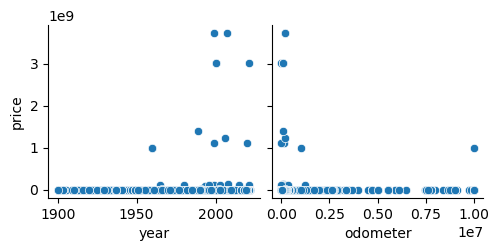

In [10]:
g = sns.pairplot(data,x_vars=['year','odometer'], y_vars=['price'],diag_kind="kde")

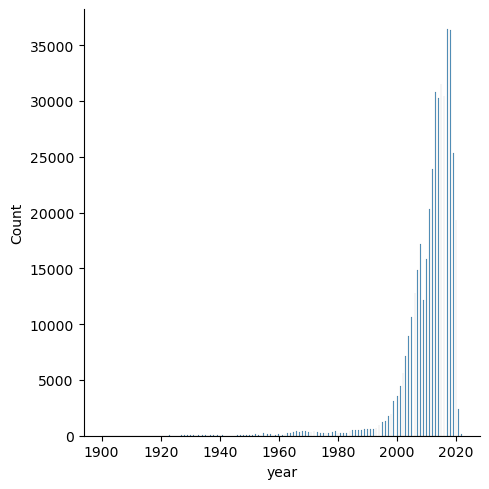

In [11]:
sns.displot(data, x="year")

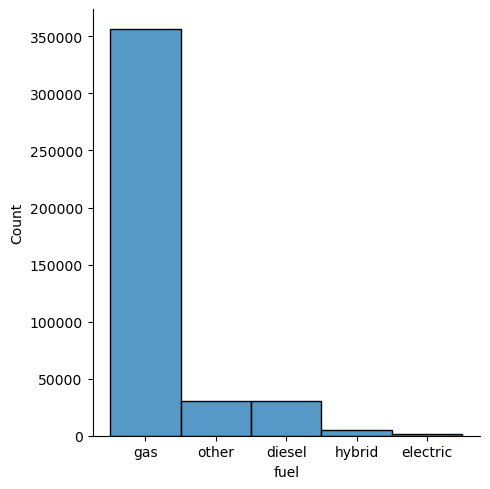

In [12]:
sns.displot(data, x="fuel")

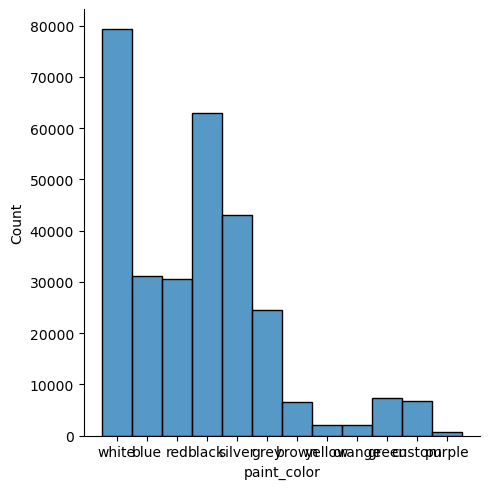

In [13]:
sns.displot(data, x="paint_color")

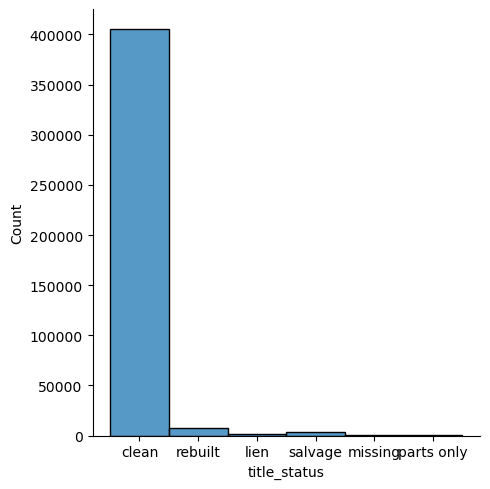

In [14]:
sns.displot(data, x="title_status")

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [15]:
#remove dups as VIN will be unique, keeping odometer highest as that will be latest data point
data = data.sort_values('odometer', ascending=True).drop_duplicates('VIN', keep='last').sort_index()
#dropping id column as it is useless in identifying price
data = data.drop(['id'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118247 entries, 50 to 426873
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        118247 non-null  object 
 1   price         118247 non-null  int64  
 2   year          117654 non-null  float64
 3   manufacturer  115186 non-null  object 
 4   model         117547 non-null  object 
 5   condition     61100 non-null   object 
 6   cylinders     70310 non-null   object 
 7   fuel          116604 non-null  object 
 8   odometer      116567 non-null  float64
 9   title_status  114587 non-null  object 
 10  transmission  116996 non-null  object 
 11  VIN           118246 non-null  object 
 12  drive         90864 non-null   object 
 13  size          30302 non-null   object 
 14  type          102135 non-null  object 
 15  paint_color   87535 non-null   object 
 16  state         118247 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usag

In [16]:
#Encode some of the features which makes sense..
onehotencoded_columns = ['manufacturer']
# Assign dataframe using pd.get_dummies to encode categorical values into separate columns
data = pd.get_dummies(data, columns=onehotencoded_columns, dtype='int', drop_first=False)

data.update(data[['region', 'condition', 'state','model','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']].apply(lambda s: s.map(data['price'].groupby(s).mean())))

finaldata = data.drop(['VIN'], axis=1)



In [17]:
#find and fill null values
finaldata.isna().sum()
finaldata.fillna(method="ffill",inplace=True)
finaldata.fillna(method="bfill",inplace=True)

finaldata

,region,price,year,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo
50,19593.333333,38990,2020.0,30860.688889,18541.618797,16339.601831,16980.612338,12231.0,18117.190935,24808.395829,21279.017339,16687.778315,26328.227784,31838.544940,17364.584139,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56,19593.333333,16590,2016.0,19409.047619,18541.618797,16339.601831,16980.612338,35835.0,18117.190935,24808.395829,21279.017339,16687.778315,19880.429472,31838.544940,17364.584139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,19593.333333,34990,2018.0,23785.695652,18541.618797,22867.198026,16980.612338,18650.0,18117.190935,24808.395829,18915.938212,16687.778315,19880.429472,19570.285963,17364.584139,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116,19593.333333,26990,2016.0,24304.428571,18541.618797,22867.198026,16980.612338,31363.0,18117.190935,24808.395829,14623.674691,16687.778315,12411.562590,19849.520547,17364.584139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
127,19593.333333,0,2019.0,17039.852941,50996.215315,16339.601831,16980.612338,69125.0,18117.190935,17417.454510,18915.938212,16687.778315,16707.539433,19849.520547,17364.584139,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426844,22070.830357,13977,2014.0,14049.316770,18541.618797,22867.198026,16980.612338,112061.0,18117.190935,17417.454510,18915.938212,34022.082357,15782.129676,19849.520547,22070.830357,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
426851,22070.830357,6577,2013.0,8334.272401,18541.618797,22867.198026,16980.612338,169396.0,18117.190935,15365.502286,18915.938212,34022.082357,16218.672732,15331.723897,22070.830357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
426852,22070.830357,6977,2011.0,9112.196388,18541.618797,22867.198026,16980.612338,112396.0,18117.190935,17417.454510,18915.938212,34022.082357,16218.672732,19849.520547,22070.830357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
426872,22070.830357,32590,2020.0,26732.661290,18541.618797,22867.198026,16980.612338,19059.0,18117.190935,24808.395829,18915.938212,34022.082357,16218.672732,19849.520547,22070.830357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
#remove outliers with Z score
finaldata = finaldata[(np.abs(zscore(finaldata)) <= 3).all(axis=1)]

In [19]:
corr = finaldata.corr().abs()

values = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack().sort_values(ascending=False))
for index, value in enumerate(values.items()):
    if index == 25:
        break
    print(index, value)
    


0 (('manufacturer_chevrolet', 'manufacturer_ford'), 0.8735514465687169)
1 (('region', 'state'), 0.6126276231495388)
2 (('price', 'model'), 0.6080733404051639)
3 (('year', 'odometer'), 0.5578837123229596)
4 (('model', 'type'), 0.4503544738388327)
5 (('price', 'year'), 0.38845903237700063)
6 (('drive', 'type'), 0.37922812430744196)
7 (('model', 'drive'), 0.37432783176440193)
8 (('price', 'odometer'), 0.35981536998610114)
9 (('cylinders', 'drive'), 0.35034952106629996)
10 (('cylinders', 'type'), 0.3366595858044709)
11 (('region', 'price'), 0.3093039695427655)
12 (('model', 'cylinders'), 0.2906454687388778)
13 (('price', 'type'), 0.2742853797446868)
14 (('price', 'drive'), 0.26707469885755925)
15 (('price', 'state'), 0.21083172557610264)
16 (('year', 'model'), 0.18047733860707346)
17 (('region', 'model'), 0.16113223121049722)
18 (('model', 'odometer'), 0.1545482152101685)
19 (('price', 'cylinders'), 0.15117030075195348)
20 (('year', 'cylinders'), 0.14689904528262757)
21 (('cylinders', 'odo

In [20]:
# Split data

X = finaldata.drop('price', axis=1)
y = finaldata['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#RFE selection


model = LinearRegression()
# Create an RFE selector 
recursive_feature_elimination = RFE(model, n_features_to_select=5)

# Fit the selector to the data
recursive_feature_elimination.fit(X_train, y_train)

# selected features
selected_features = X_train.columns[recursive_feature_elimination.support_]

print(selected_features)

Index(['year', 'model', 'transmission', 'manufacturer_chevrolet',
       'manufacturer_ford'],
      dtype='object')


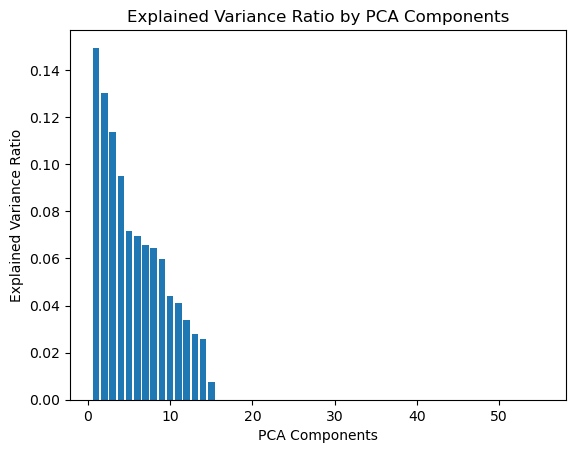

In [22]:
#PCA model
# Scale numerical features
pca_columns = finaldata.columns
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X_train)

# Apply PCA on scaled numerical features
pca = PCA()
transformed_numerical = pca.fit_transform(scaled_numerical)
# Bar graph for explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by PCA Components')
plt.show()

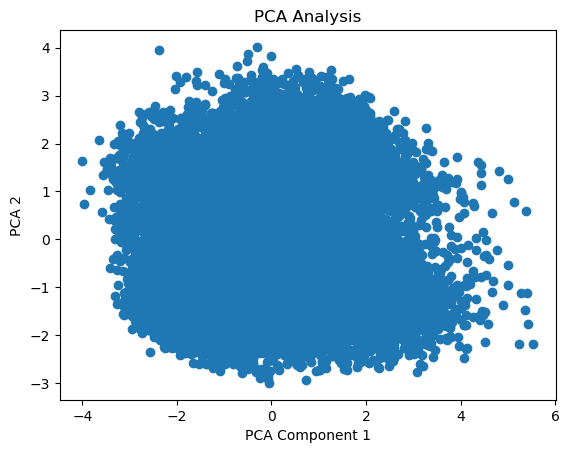

In [23]:
plt.scatter(transformed_numerical[:, 0], transformed_numerical[:, 1])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA 2")
plt.title("PCA Analysis")
plt.show()


In [46]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
finaldata.columns.values
loadings_df['variable'] = X_train.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df
loadings_df.sort_values(by=['PC1'],ascending=False)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
model,4.948943e-01,-2.249193e-02,-3.007272e-02,-2.015200e-01,7.629094e-02,7.963852e-02,5.277645e-02,9.514316e-02,-5.577116e-02,-2.801444e-01,1.734812e-01,7.543594e-01,-6.504175e-02,-4.434588e-02,-4.600902e-02,-5.061863e-17,8.945157e-18,-2.125963e-17,6.475818e-17,-4.876153e-17,6.901039e-17,2.416999e-17,1.650264e-17,0.0,0.0,0.0,0.0,2.634692e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
type,4.704595e-01,1.008618e-01,1.496289e-01,-1.165873e-01,4.091118e-03,7.110804e-02,6.390487e-02,3.059016e-02,2.021086e-02,-5.262645e-01,2.838100e-01,-5.928268e-01,9.768230e-02,4.200264e-02,4.195399e-02,9.300067e-18,-1.320939e-16,-1.639644e-17,-1.225930e-16,-1.395247e-18,-1.658533e-16,4.428974e-17,1.047859e-16,0.0,0.0,0.0,0.0,-3.328855e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
drive,4.378801e-01,9.405614e-02,1.883000e-01,-1.352492e-01,9.424319e-02,-1.747402e-02,8.364294e-02,1.958493e-02,-9.428234e-02,1.580077e-01,-8.264429e-01,-8.153121e-02,7.273886e-02,-1.559986e-02,7.292000e-03,4.542459e-17,-6.435756e-17,5.511469e-17,-3.905548e-17,6.936118e-17,-4.935668e-18,-1.645897e-18,1.758372e-17,0.0,0.0,0.0,0.0,7.465265e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cylinders,3.734923e-01,2.428516e-01,2.227769e-01,-1.713521e-02,6.043077e-03,-5.464754e-04,-7.033718e-02,7.829672e-02,-6.141635e-02,7.366067e-01,4.222339e-01,-7.336027e-02,-9.155948e-02,-1.659551e-02,4.249347e-02,-3.158882e-18,1.179611e-17,-2.560388e-17,-1.454530e-17,-1.063308e-17,2.151864e-17,8.696900e-17,5.124626e-17,0.0,0.0,0.0,0.0,3.900984e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
region,2.940637e-01,-1.225560e-01,-3.042845e-01,5.396230e-01,-3.256730e-02,-3.942186e-02,-1.320083e-02,-6.727964e-02,2.079353e-02,3.322322e-02,-3.859601e-02,1.019012e-02,-7.580951e-02,7.060638e-01,2.498382e-03,2.620478e-19,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
state,2.738882e-01,-1.308282e-01,-2.847999e-01,5.670977e-01,-2.944726e-02,-6.082607e-02,-2.820764e-02,-5.296132e-02,5.075106e-02,7.986410e-03,-1.307162e-02,-5.070737e-02,7.720058e-02,-6.967808e-01,-1.207868e-02,5.564924e-17,2.738966e-17,8.005494e-17,-1.761787e-17,1.807853e-17,1.794604e-17,1.402227e-16,-1.320709e-16,0.0,0.0,0.0,0.0,-2.918117e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fuel,1.149842e-01,3.478513e-02,-4.611619e-02,-1.784830e-01,-6.248894e-01,-8.715246e-02,3.286283e-02,-1.030101e-01,7.264162e-01,6.455399e-02,-5.585116e-02,5.587543e-02,5.977165e-02,9.895480e-03,7.259522e-03,-4.921329e-17,-2.438058e-17,4.572274e-17,-6.855507e-17,-1.492472e-17,-8.659039e-17,4.730337e-17,-1.077863e-16,0.0,0.0,0.0,0.0,-6.691819e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
year,1.043486e-01,-2.929031e-01,-4.629397e-01,-3.795598e-01,7.531908e-02,-5.778864e-02,-2.861729e-02,-6.134584e-03,-3.834825e-03,7.810332e-02,-3.545170e-02,-2.159609e-01,-6.809026e-01,-8.045623e-02,1.046855e-01,-3.072215e-17,7.425567e-17,3.039517e-17,1.110223e-16,3.122502e-17,6.245005e-17,2.445200e-17,1.214306e-17,0.0,0.0,0.0,0.0,-1.628853e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
manufacturer_ford,5.869662e-02,-5.94481

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [25]:


# Create a column transformer to apply one-hot to selected variables
col_transformer_train = make_column_transformer(
        (OneHotEncoder(drop='if_binary', handle_unknown='ignore'), X_train.columns.tolist()),
        remainder='passthrough'
)

# Fit and transform the column transformer with training data
X_train_transformed = col_transformer_train.fit_transform(X_train)

# Create a new column transformer for test data
col_transformer_test = make_column_transformer(
        (OneHotEncoder(drop='if_binary', handle_unknown='ignore'), X_train.columns.tolist()),
        remainder='passthrough'
)

# Fit the column transformer with training data (it already transformed X_train)
col_transformer_test.fit(X_train)

# Transform X_test using the col_transformer_test
X_test_transformed = col_transformer_test.transform(X_test)

# Create a Pipeline for data processing with linear regression
pipe = Pipeline([
        ('linreg', LinearRegression())
])

# Train the pipeline on the transformed training data
pipe.fit(X_train_transformed, y_train)

# Predict y from the transformed test dataset
y_test_pred = pipe.predict(X_test_transformed)

# Predict y from our test dataset
y_train_pred = pipe.predict(X_train_transformed)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_test_pred)
print("Y Test MSE:", mse)
# Calculate mean squared error
mse = mean_squared_error(y_train, y_train_pred)
print("Y Train MSE:", mse)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_test_pred)
print(f"R-squared (Coefficient of Determination): {r2}")

Y Test MSE: 168754271.59119785
Y Train MSE: 3728939.701984654
R-squared (Coefficient of Determination): 0.15649912415780498


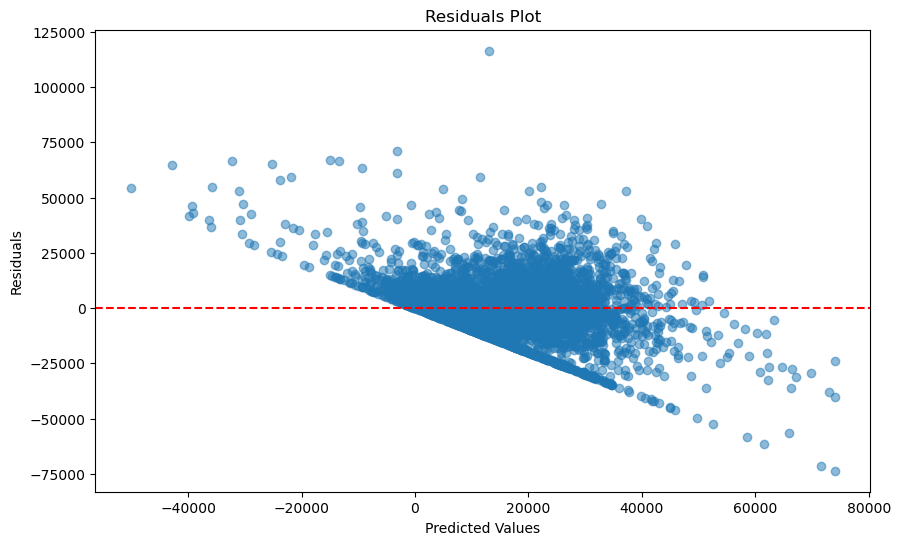

In [26]:
# Calculate residuals
residuals = y_test - y_test_pred

# Create a DataFrame with residuals
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Residuals': residuals})

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(residuals_df['Predicted'], residuals_df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


In [27]:


# Create a Pipeline for data processing with linear regression
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('linreg', LinearRegression())
])

# Train the pipeline on the transformed training data
pipe.fit(X_train_transformed, y_train)

# Predict y from our test dataset
y_train_pred = pipe.predict(X_train_transformed)

# Predict y from the transformed test dataset
y_test_pred = pipe.predict(X_test_transformed)


# Calculate mean squared error
mse = mean_squared_error(y_test, y_test_pred)
print("Y Test MSE:", mse)
# Calculate mean squared error
mse = mean_squared_error(y_train, y_train_pred)
print("Y Train MSE:", mse)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_test_pred)
print(f"R-squared (Coefficient of Determination): {r2}")

Y Test MSE: 168766169.0436156
Y Train MSE: 3728933.906139738
R-squared (Coefficient of Determination): 0.15643965596514808


In [28]:

# Create a LinearRegression model
linreg = LinearRegression()

# Train the model on the training data
linreg.fit(X_train, y_train)

# Predict y from the test dataset
y_test_pred = linreg.predict(X_test)

# Predict y from the training dataset
y_train_pred = linreg.predict(X_train)

# Calculate mean squared error for test data
mse_test = mean_squared_error(y_test, y_test_pred)
print("Y Test MSE:", mse_test)

# Calculate mean squared error for train data
mse_train = mean_squared_error(y_train, y_train_pred)
print("Y Train MSE:", mse_train)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_test_pred)
print(f"R-squared (Coefficient of Determination): {r2}")

Y Test MSE: 97750013.22987713
Y Train MSE: 101567200.59021978
R-squared (Coefficient of Determination): 0.511406609174756


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [29]:

# Define the parameter grid for grid search
param_grid = {
    'linreg__fit_intercept': [True, False]
}

# Create a Pipeline for data processing with linear regression
pipe = Pipeline([
    ('linreg', LinearRegression())
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train models using grid search
grid_search.fit(X_train_transformed, y_train)

# Get the best estimator from grid search
best_pipe = grid_search.best_estimator_

# Predict y from the transformed test dataset using the best model
y_test_pred = best_pipe.predict(X_test_transformed)

# Predict y from the training dataset using the best model
y_train_pred = best_pipe.predict(X_train_transformed)

# Calculate mean squared error for test data
mse_test = mean_squared_error(y_test, y_test_pred)
print("Y Test MSE:", mse_test)

# Calculate mean squared error for train data
mse_train = mean_squared_error(y_train, y_train_pred)
print("Y Train MSE:", mse_train)

# Calculate R-squared (Coefficient of Determination)
r2 = r2_score(y_test, y_test_pred)
print(f"R-squared (Coefficient of Determination): {r2}")


Y Test MSE: 167992201.59929857
Y Train MSE: 3729488.081120623
R-squared (Coefficient of Determination): 0.16030825265902182


In [30]:

# Add polynomial features
degree = 2  # Change the degree as needed
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a LinearRegression model
linreg = LinearRegression()

# Hyperparameter tuning using GridSearch
param_grid = {
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(estimator=linreg, param_grid=param_grid, cv=5)
grid_search.fit(X_train_poly, y_train)

best_linreg = grid_search.best_estimator_

# Train the best model on the training data
best_linreg.fit(X_train_poly, y_train)

# Predict y from the test dataset using the best model
y_test_pred_best = best_linreg.predict(X_test_poly)

# Predict y from the training dataset using the best model
y_train_pred_best = best_linreg.predict(X_train_poly)

# Calculate mean squared error for test data using the best model
mse_test_best = mean_squared_error(y_test, y_test_pred_best)
print("Best Model Y Test MSE:", mse_test_best)

# Calculate mean squared error for train data using the best model
mse_train_best = mean_squared_error(y_train, y_train_pred_best)
print("Best Model Y Train MSE:", mse_train_best)

# Calculate R-squared (Coefficient of Determination) for test data using the best model
r2_best = r2_score(y_test, y_test_pred_best)
print(f"Best Model R-squared (R2) (Coefficient of Determination): {r2_best}")

Best Model Y Test MSE: 87055648.72713995
Best Model Y Train MSE: 88026018.84691595
Best Model R-squared (R2) (Coefficient of Determination): 0.5648612905856472


In [31]:
# Define the number of folds
n_folds = 5

# Create regression models
linear_reg_model = LinearRegression()

# Define the mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error)

# Perform K-Fold Cross-Validation for Linear Regression
linear_reg_scores = cross_val_score(linear_reg_model, X, y, cv=n_folds, scoring=scorer)
linear_reg_mse = linear_reg_scores.mean()



# Print the mean squared error for each model
print("Linear Regression Cross validation MSE:", linear_reg_mse)

Linear Regression Cross validation MSE: 101855762.73575526


In [32]:
# Define the number of folds
n_folds = 5

# Create a Random Forest Regressor model
lg = LinearRegression()

# Fit the model on your training data
lg.fit(X, y)

# Perform cross-validation to get mean squared error scores
mse_scores = cross_val_score(lg, X, y, cv=n_folds, scoring='neg_mean_squared_error')

# Convert negative scores to positive (mean squared error)
mse_scores = -mse_scores

# Calculate the average mean squared error
average_mse = mse_scores.mean()

# Print the mean squared error for each fold
for i, mse in enumerate(mse_scores):
    print(f"Fold {i+1} MSE: {mse}")

# Print the average mean squared error
print("Average MSE:", average_mse)

# Perform cross-validation to get predicted target values
predicted_y = cross_val_predict(lg, X, y, cv=n_folds)

# Calculate R-squared
r_squared = lg.score(X, y)

# Print R-squared
print("R-squared (R2) (Coefficient of Determination):", r_squared)

# Calculate Mean Squared Error between predicted and actual target values
mse = mean_squared_error(y, predicted_y)
print("Overall MSE:", mse)


Fold 1 MSE: 99605140.83982237
Fold 2 MSE: 83995661.31616487
Fold 3 MSE: 93804844.42702927
Fold 4 MSE: 115990854.46160188
Fold 5 MSE: 115882312.63415797
Average MSE: 101855762.73575526
R-squared (R2) (Coefficient of Determination): 0.5143173709071208
Overall MSE: 101855674.14951988


### Summary of Model Performance and Valdiation

There are several models that I have applied to investigate whick model will be best fit.I have performed PCA analysis, Linerar Regression, Polynomical features and also evaluated with GridSearch. Also performed cross validation with several techniques

Results summary:

Linear Regression

Y Test MSE: 168754271.59119785
Y Train MSE: 3728939.701984654
R-squared (Coefficient of Determination): 0.15649912415780498

Linear Regression with Polynomial Features Degree 1:


Y Test MSE: 168766169.0436156
Y Train MSE: 3728933.906139738
R-squared (Coefficient of Determination): 0.15643965596514808

Grid Search Evaluation with n=5

Y Test MSE: 167992201.59929857
Y Train MSE: 3729488.081120623
R-squared (Coefficient of Determination): 0.16030825265902182


With 85% explainable model seems to be good with 15% unexplainability from the model


Next Steps:
I would like evalutate further the model on some of the features how we can encode better and run other techniques to see if we can improve the model further to explain the possiblity of reamining 15%.

I would like to create model with only the columns that has more importance and see how these models perform and perdict with more accuracy.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Final Report:
Based on PCA analysis the used car dearship need consider the vehicles that has the below features. The used car prices are driven by model,type,drive,cylinders,region,state,fuel,year,made by ford,paint_color,transmission and condition.

Using Linear regression we are only unable to explain 15% of variance in the model, means with 85% accuracy it will predict.

We can further narrow down what are the top features that drives used car price as a next step.


